Detour from Time_Series_more.ipynb, need to solidify my understanding of Holt-Winters.  Here is a breakdown of what holt-winters algorithm is doing.

[source](https://grisha.org/blog/2016/01/29/triple-exponential-smoothing-forecasting/)

In [1]:
series = [3, 10, 12, 13, 12, 10, 12]

In [2]:
def naive_method(series):
    return series[-1]

In [3]:
naive_method(series)

12

In [4]:
def average(series):
    return float(sum(series)/len(series))

In [5]:
average(series)

10.285714285714286

In [9]:
def average(series, n=None):
    if n is None:
        return average(series, n=len(series))
    return float(sum(series[-n:])/n)  #average of n last points

In [10]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1]*weights[n]
    return result

alpha can be interpreted as the smoothing factor, dictates how much weight to put on the most recent observed value. Can think of alpha as *memory decay rate*

y_pred_t = alpha\*y_t + (1 - alpha)\*y_t-1

In [11]:
def exponential_smoothing(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha*series[n] + (1 - alpha)*result[n-1])
    return result
        

In [12]:
exponential_smoothing(series, 0.1)

[3, 3.7, 4.53, 5.377, 6.0393, 6.43537, 6.991833]

In [14]:
exponential_smoothing(series, .9)

[3, 9.3, 11.73, 12.873000000000001, 12.0873, 10.20873, 11.820873]

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series):
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result
        

In [16]:
double_exponential_smoothing(series, alpha=0.9, beta=.9)

[3,
 17.0,
 15.45,
 14.210500000000001,
 11.396044999999999,
 8.183803049999998,
 12.753698384500002]

In [18]:
series = [30,21,29,31,40,48,53,47,37,39,31,29,17,9,20,24,27,35,41,38,
          27,31,27,26,21,13,21,18,33,35,40,36,22,24,21,20,17,14,17,19,
          26,29,40,31,20,24,18,26,17,9,17,21,28,32,46,33,23,28,22,27,
          18,8,17,21,31,34,44,38,31,30,26,32]

In [20]:
import matplotlib.pyplot as plt

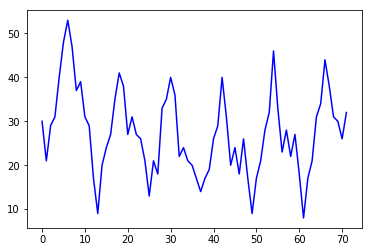

In [22]:
plt.plot(series, 'b-')

In [23]:
def initial_trend(series, slen):
    sum = 0.0
    for i in range(slen):
        sum += float(series[i+slen] - series[i]) / slen
    return sum / slen

In [24]:
initial_trend(series, 12)

-0.7847222222222222

In [25]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [27]:
initial_seasonal_components(series, 12)

{0: -7.4305555555555545,
 1: -15.097222222222221,
 2: -7.263888888888888,
 3: -5.097222222222222,
 4: 3.402777777777778,
 5: 8.069444444444445,
 6: 16.569444444444446,
 7: 9.736111111111112,
 8: -0.7638888888888887,
 9: 1.902777777777778,
 10: -3.263888888888889,
 11: -0.7638888888888887}

In [29]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0 :
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series):
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen])+ (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen]=gamma*(val-smooth)+(1-gamma)*seasonals[i%slen]
            result.append(smooth + trend + seasonals[i%slen])    
    return result

In [31]:
results = triple_exponential_smoothing(series, 12, 0.716, 0.029, 0.993, 24)

In [32]:
actual_values = results[:-24]

In [33]:
len(actual_values)

72

In [34]:
predicted_values = results[-24:]

In [35]:
len(predicted_values)

24

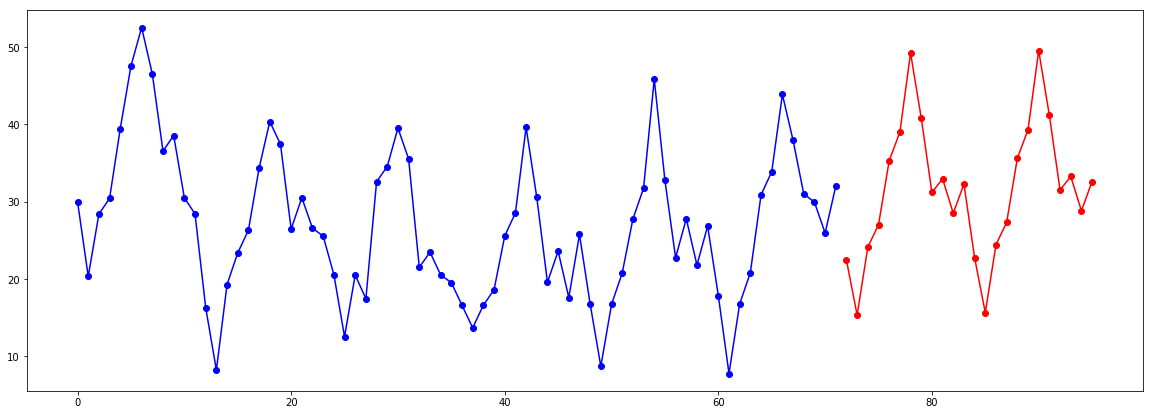

In [43]:
plt.figure(figsize=(20, 7))
plt.plot(actual_values, 'b-')
plt.plot(actual_values, 'bo')
plt.plot(range(72, 96), predicted_values, 'r-')
plt.plot(range(72,96), predicted_values, 'ro')
